## Preprocessing
### 불러온 각 데이터셋 별 전처리 필요한 항목
1. Product 
- **1.1** HITS_SEQ 1~2인 경우, 모두 삭제 한다. 그 어떤 경우에도 클릭 한 두 번에 의해 구매가 가능하지 않다. 물론 Session의 TOT_PAG_VIEW_CT가 1이고 TOT_SESS_HR_V가 3초 미만인 경우와 같은 경우 자정이 지남과 동시에 세션이 새롭게 할당되면서 한 번의 클릭으로 구매가 이루어졌을 수도 있다. 그러나 원래의 HITS_SEQ(Raw)는 기업에 이미 존재하나 내가 제공받지 못했기 때문에 실로 그런것인지 아닌지 유츄하는 것은 의미가 없다. 한마디로 제공받은 데이터셋들로는 구매 과정에서 새로운 세션 할당과 동시에 한 번의 클릭으로 구매가 이루어진 경우라고 확정할 수는 없다. 

접속해서 로그인만해도 Hit가 기록됨. 단 한 번의 Hit로 주문하려면 접속하자마자 전에 장바구니에 담아놓았던 상품들을 주문하기를 바로 눌러야함. Hit가 1~2인데 SESS_HR와 PAG_VIEW가 많은 경우는 뭘까?


- Session과 병합 이후 살펴볼 예정

2. Custorm 
- **2.1** 롯데멤버십 회원을 목적으로 할 것이기 때문에 Proudct와 병합하면서 발생하는 결측치들, 즉 비회원에 해당하는 row 삭제할 예정

3. Master 
- **3.1**대분류 항목 간소화 해야함. 내구재vs비내구재/

4. Session 
- **4.1** TOT_PAG_VIEW_CT와 TOT_SESS_HR_V 두 변수에서 이미 결측치들이 존재함. 해당 row 모두 삭제해야함.
- TOT_SESS_HR_V의 값이 0인 것은 없고 TOT_PAG_VIEW_CT 값이 1인 경우 TOT_SESS_HR_V 값이 결측치인 것이 98%임. 그러므로 TOT_SESS_HR_V의 결측치는 할당된 세션에서 1초 미만으로, 즉 켜지자마자 끈 것으로 판단할 수 있다. 따라서 결측치에 0의 값을 부여할 수는 있으나 정보 탐색에 초점을 맞춘 본 연구의 관점에서 보면 탐색을 위해 할당 받은 새로운 세션을 채 1초가 되지도 않은 시점에 본인에게 필요한 것인지 필요하지 않은 것인지 판단 후 세션을 종료했다기 보다는, 클릭을 잘못하거나 오류인 것으로 판단한다. 또 Session 외에도 Product, Search1에 있는 Session_ID는 모두 구매가 이루어진 세션이기 때문에 1초 안에 구매가 이루어졌다고 볼 수는 없다. 결제 과정에서 자정이지나 세션이 새로 할당되면서 동시에 구매가 이루어진 경우일 가능성이 있다. 그러나 제공받은 어떠한 데이터로도 그 경우임을 확정할 수 없고, 따라서 변수에 대한 보정을 통해 이를 연구에 반영할 수 없는 바. TOT_SESS_HR_V가 지나치게 짧은 row들은 모두 삭제한다. 그러나 그 기준을 어떻게 산정할지는 여전히 문제로 남는다. 

- TOT_SESS_HR_V가 결측치가 아님에도 TOT_PAG_VIEW_CT가 결측치인 경우는 세션 오류로 판단함. 

- Product의 Hit 대비 세션 유지시간, 페이지 뷰 등을 고려하여 작은 것들을 삭제함. 


**7** 

7.1 CLNT_ID = SESS_ID=SESS_DT=HITS_SEQ=PC_C -> 같은 고객이 같은 날 할당 받은 한 세션에서 같은 상품의 서로 다른 옵션을 같은 시점(Hit)에 구매함 

7.2 CLNT_ID = SESS_ID=SESS_DT=PD_C≠HITS_SEQ -> 같은 고객이 같은 날 할당 받은 한 세션에서 같은 상품을 다른 시점(Hit)에 구매함. 

HITS_SEQ만 다른 두 번째의 경우 구매 이력 데이터만 있기 때문에 중간 과정이 생략되어 이것이 구매-> 환불->재구매인지, 추가 구매인지 다른 옵션 구매인지 이렇게 필터링만 해서는 알 수 없다. 

다른 옵션 구매인 것은 PD_ADD_NM을 통해 확인이 가능하나 순간 변심으로 구매취소에 따른 재구매인지 추가 구매인지는 중간과정이 생략되어 있기 때문에 결국엔 알 방도가 없다. 따라서 그 경우가 적다고 해도 편향을 발생시키기 때문에 제거한다. 





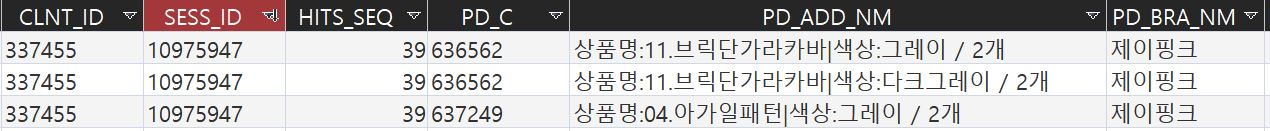

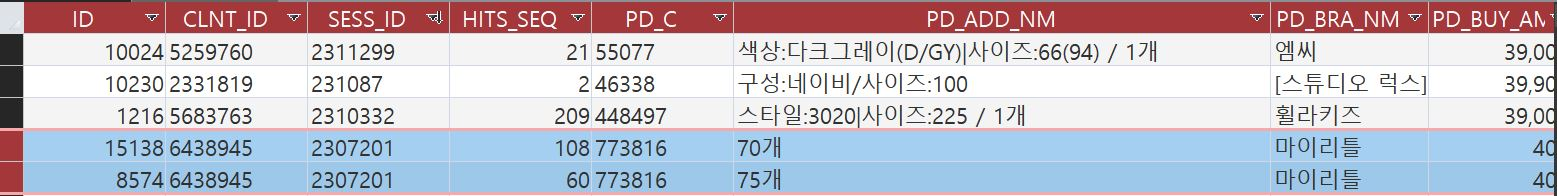


In [46]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#출력 한 번에 나올 수 있게 설정
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
filename='/content/drive/My Drive/DataSet/Lpoint/data/Product.csv'

In [5]:
prd = pd.read_csv(filename, dtype={"CLNT_ID":np.str, "SESS_ID":np.str},thousands=",") #파일 불러오기
prd.head()
prd.dtypes
prd.shape
#행이 5024906, Product가 구매 이력 데이터이기 때문에 행의 수가 곧 6개월 간 구매빈도

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,07605037,12,642112,색상:워터멜론,[바비브라운],39000,1
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,39000,2
2,4142395,06158159,85,179538,(not set),[아베다],39000,1
3,4144914,07935714,12,554336,색상:블랙|사이즈:160cm(12~13세) / 1개,아디다스 키즈,39000,1
4,4144917,06406509,78,190306,5개,데코르테,39000,5


CLNT_ID      object
SESS_ID      object
HITS_SEQ      int64
PD_C          int64
PD_ADD_NM    object
PD_BRA_NM    object
PD_BUY_AM     int64
PD_BUY_CT     int64
dtype: object

(5024906, 8)

In [6]:
prd.isna().sum() #결측치 없음

CLNT_ID      0
SESS_ID      0
HITS_SEQ     0
PD_C         0
PD_ADD_NM    0
PD_BRA_NM    0
PD_BUY_AM    0
PD_BUY_CT    0
dtype: int64

In [7]:
mastercsv='/content/drive/My Drive/DataSet/Lpoint/data/Master.csv'
master = pd.read_csv(mastercsv)

In [8]:
master.head()

,PD_C,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM
0,64382,언더아머 남성 UA HG 아머 모크 LS 1289559-001 - 블랙 / MD[95],스포츠패션,남성일반스포츠의류,남성스포츠티셔츠
1,62282,여자 플라워덧신 2족선물세트 17403-2set,속옷/양말/홈웨어,여성양말류,여성일반양말
2,61729,88A2933253배트맨스웨트티 - 블랙 / 130,유아동의류,유아의류상의,영유아티셔츠/탑
3,61537,"닥터마틴 아드리안 블랙, 체리레드 - 02_체리레드 / 250mm(6)",패션잡화,남성화,남성부츠
4,58820,여성 그레이 스트라이프 퍼프 소매 블라우스 (128865YQ33) - 회색(앤틱실버...,남성의류,남성의류상의,남성남방셔츠


In [9]:
#분석에 쓸모 없는 일부 변수 삭제
#집단 간 분석을 하는 데에 있어서 대분류 37개도 많다고 느꼈기 때문에 품명, 중분류, 소분류 삭제 
master.drop(['PD_NM', 'CLAC2_NM', 'CLAC3_NM'], axis='columns', inplace=True)

In [10]:
#파생변수 추가를 위해 CLAC1_NM 변수를 CLAC4_NM이라는 이름으로 똑같이 하나 더 추가 
master['CLAC4_NM'] = master['CLAC1_NM'] 
master['CLAC5_NM'] = master['CLAC1_NM'] 
master.head()

,PD_C,CLAC1_NM,CLAC4_NM,CLAC5_NM
0,64382,스포츠패션,스포츠패션,스포츠패션
1,62282,속옷/양말/홈웨어,속옷/양말/홈웨어,속옷/양말/홈웨어
2,61729,유아동의류,유아동의류,유아동의류
3,61537,패션잡화,패션잡화,패션잡화
4,58820,남성의류,남성의류,남성의류


In [11]:
# 복사했던 파생변수를 내구재, 준내구재, 비내구재로 변환함. 상품권은 일단 냅뒀음. 바로 삭제할 것임. 
master=master.replace({'CLAC4_NM':{'가구':'내구재' ,'건강식품': '비내구재', '계절가전':'내구재', '과일':'비내구재', '구기/필드스포츠':'준내구재', '남성의류':'준내구재', '냉동식품':'비내구재', '냉장/세탁가전':'내구재',
       '냉장식품':'비내구재', '모바일':'내구재', '문구/사무용품':'비내구재', '상품권':'상품권', '생활/주방가전':'내구재', '세제/위생':'비내구재', '속옷/양말/홈웨어':'준내구재',
       '스포츠패션':'준내구재', '시즌스포츠':'준내구재', '식기/조리기구':'준내구재', '아웃도어/레저':'준내구재', '여성의류':'준내구재', '영상/음향가전':'내구재', '완구':'준내구재',
       '원예/애완':'비내구재', '유아동의류':'준내구재', '음료':'비내구재', '인테리어/조명':'내구재', '자동차용품':'내구재', '주방잡화':'준내구재', '청소/세탁/욕실용품':'비내구재', '축산물':'비내구재',
       '출산/육아용품':'준내구재', '침구/수예':'비내구재', '컴퓨터':'내구재', '패션잡화':'준내구재', '퍼스널케어':'비내구재', '헬스/피트니스':'준내구재', '화장품/뷰티케어':'비내구재'}})

In [12]:
#통계청의 기준에 따른 상품 분류
#가전(컴퓨터 및 주변기기, 가전 전자 통신기기) / 도서(서적, 사무 및 문구) / 패션 / 식품 / 생활(생활용품, 자동차 및 자동차용품, 가구, 애완용품) / 서비스(여행 및 교통서비스, 문화 및 레저서비스, e쿠폰서비스, 음식서비스)

master=master.replace({'CLAC5_NM':{'가구':'생활' ,'건강식품': '식품', '계절가전':'가전', '과일':'식품', '구기/필드스포츠':'생활', '남성의류':'패션', '냉동식품':'식품', '냉장/세탁가전':'가전',
       '냉장식품':'식품', '모바일':'가전', '문구/사무용품':'도서', '상품권':'상품권', '생활/주방가전':'가전', '세제/위생':'생활', '속옷/양말/홈웨어':'패션',
       '스포츠패션':'패션', '시즌스포츠':'생활', '식기/조리기구':'생활', '아웃도어/레저':'패션', '여성의류':'패션', '영상/음향가전':'가전', '완구':'도서',
       '원예/애완':'생활', '유아동의류':'패션', '음료':'식품', '인테리어/조명':'생활', '자동차용품':'생활', '주방잡화':'생활', '청소/세탁/욕실용품':'생활', '축산물':'식품',
       '출산/육아용품':'생활', '침구/수예':'생활', '컴퓨터':'가전', '패션잡화':'패션', '퍼스널케어':'식품', '헬스/피트니스':'생활', '화장품/뷰티케어':'패션'}})

In [13]:
master.head() #CLAC4_NM 잘 변환 되었음.

,PD_C,CLAC1_NM,CLAC4_NM,CLAC5_NM
0,64382,스포츠패션,준내구재,패션
1,62282,속옷/양말/홈웨어,준내구재,패션
2,61729,유아동의류,준내구재,패션
3,61537,패션잡화,준내구재,패션
4,58820,남성의류,준내구재,패션


In [14]:
len(master) #Master의 총 행의 개수이자 품목의 개수

847652

In [15]:
#대분류 상품권에 해당하는 행 삭제
master=master[master.CLAC1_NM !='상품권']
len(master) #상품권 삭제 후 남은 행 
master.head()

845688

,PD_C,CLAC1_NM,CLAC4_NM,CLAC5_NM
0,64382,스포츠패션,준내구재,패션
1,62282,속옷/양말/홈웨어,준내구재,패션
2,61729,유아동의류,준내구재,패션
3,61537,패션잡화,준내구재,패션
4,58820,남성의류,준내구재,패션


In [16]:
#데이터셋 결합을 위해 파일 불러오기
customcsv='/content/drive/My Drive/DataSet/Lpoint/data/Custom.csv'
custom = pd.read_csv(customcsv, dtype={"CLNT_ID": np.str})

sessioncsv='/content/drive/My Drive/DataSet/Lpoint/data/Session.csv'
session = pd.read_csv(sessioncsv, dtype={"CLNT_ID": np.str, "SESS_ID":np.str}, thousands=",")

In [17]:
#데이터셋 결합
prdmas = pd.merge(prd,master[["PD_C", "CLAC1_NM", "CLAC4_NM", "CLAC5_NM"]],on=['PD_C'],how='left') #Product(구매이력)와 상품분류()
prdmc = pd.merge(prdmas,custom,on=['CLNT_ID'],how='left')
prdmcs = pd.merge(prdmc, session, how='inner', on=['CLNT_ID', 'SESS_ID'])

#코드 자체가 너무 비효율적인 것 같음. 더 빠르게 할 수 있는 방법 찾아야함. 

In [18]:
#구매 상품 가격과 개수에 따른 소비자의 총 구매가격 변수(TOT_PRICE) 생성
prdmcs['TOT_PRICE'] = prdmcs['PD_BUY_AM']*prdmcs['PD_BUY_CT']
prdmcs.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,TOT_PRICE
0,4139680,07605037,12,642112,색상:워터멜론,[바비브라운],39000,1,화장품/뷰티케어,비내구재,패션,NaN,NaN,1,20180526,21.0,902.0,desktop,Seoul,Seoul,39000
1,4139680,07605037,12,401577,색상:몰리 와우,[바비브라운],39000,1,화장품/뷰티케어,비내구재,패션,NaN,NaN,1,20180526,21.0,902.0,desktop,Seoul,Seoul,39000
2,4139680,07605037,28,401577,색상:몰리 와우,[바비브라운],39000,1,화장품/뷰티케어,비내구재,패션,NaN,NaN,1,20180526,21.0,902.0,desktop,Seoul,Seoul,39000
3,4139680,07605037,28,642112,색상:카바나,[바비브라운],39000,1,화장품/뷰티케어,비내구재,패션,NaN,NaN,1,20180526,21.0,902.0,desktop,Seoul,Seoul,39000
4,4139680,07605037,12,642112,색상:카바나,[바비브라운],39000,1,화장품/뷰티케어,비내구재,패션,NaN,NaN,1,20180526,21.0,902.0,desktop,Seoul,Seoul,39000


In [19]:
 #결측치 존재
 #ⓐ TOT_SESS_HR_V의 경우, 세션 별 접속 시간의 차이로 구하는 것이기 때문에 조회 페이지가 1개일 경우 시점을 비교할 상대가 없어 측정되지 않는다. 따라서 TOT_SESS_HR_V가 결측치일 때 PAG_VIEW_CT가 몇인지 보자
 #ⓑ Custom에 없는 비회원들의 구매이력임. 그러나 CLAC1의 결측치는 뭔지 모르겠다. 
prdmcs.isna().sum()

CLNT_ID                  0
SESS_ID                  0
HITS_SEQ                 0
PD_C                     0
PD_ADD_NM                0
PD_BRA_NM                0
PD_BUY_AM                0
PD_BUY_CT                0
CLAC1_NM             13497
CLAC4_NM             13497
CLAC5_NM             13497
CLNT_GENDER        1036319
CLNT_AGE           1036319
SESS_SEQ                 0
SESS_DT                  0
TOT_PAG_VIEW_CT        435
TOT_SESS_HR_V        20320
DVC_CTG_NM               0
ZON_NM                   0
CITY_NM                  0
TOT_PRICE                0
dtype: int64

In [20]:
#ⓐ TOT_SESS_HR_V 결측치 확인 
sessna = prdmcs[prdmcs['TOT_SESS_HR_V'].isnull()]
sessna['TOT_PAG_VIEW_CT'].value_counts()

1.0    19799
2.0      100
3.0        3
5.0        1
7.0        1
Name: TOT_PAG_VIEW_CT, dtype: int64

In [21]:
round(19799/len(sessna)*100,2) #TOT_SESS_HR_V가 결측치일 때 TOT_PAG_VIEW_CT가 1인 비율 97.44%

97.44

In [22]:
sessna = prdmcs[prdmcs['TOT_PAG_VIEW_CT'].isnull()]

In [23]:
len(sessna)

435

In [24]:
#ⓑ CLAC1_NM 결측치 확인
#left join한 master의 CLAC1_NM에서 결측치 13497개가 보임. 구매이력엔 있는데 master에 없어서 생긴것인지 아니면 조인을 잘못해서 발생한 것인지 확인해봐야함
#CLAC1_NM 열에 NaN이 있는 행만 추출
prdmcs[prdmcs['CLAC1_NM'].isnull()]

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,TOT_PRICE
638,5090518,07936669,68,325616,이용일(대인):05월21일 / 4개,설악한화워터피아,39000,4,NaN,NaN,NaN,F,40.0,28,20180521,88.0,2831.0,mobile,Seoul,Seoul,156000
639,5090518,07936669,90,325549,이용일(소인):05월21일 / 1개,설악한화워터피아,30500,1,NaN,NaN,NaN,F,40.0,28,20180521,88.0,2831.0,mobile,Seoul,Seoul,30500
640,5090518,07936669,57,325549,이용일(소인):05월21일 / 1개,설악한화워터피아,30500,1,NaN,NaN,NaN,F,40.0,28,20180521,88.0,2831.0,mobile,Seoul,Seoul,30500
1435,0280089,00953748,49,390491,1개,지에스25,250,1,NaN,NaN,NaN,M,20.0,10,20180914,40.0,240.0,mobile,Ulsan,Ulsan,250
1436,0882118,10086296,40,567709,1개,씨유,250,1,NaN,NaN,NaN,F,30.0,18,20180415,46.0,359.0,mobile,Gyeonggi-do,Uiwang-si,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009653,2436109,07342334,23,313966,1개,켄싱턴호텔 여의도,39010,1,NaN,NaN,NaN,F,20.0,46,20180531,21.0,523.0,mobile,Seoul,Seoul,39010
5013429,1113071,02957743,2,77973,1개,토다이,39800,1,NaN,NaN,NaN,F,40.0,3,20180811,25.0,329.0,mobile,Seoul,Seoul,39800
5016231,0003319,06436633,20,208850,1개,에버랜드,39900,1,NaN,NaN,NaN,F,30.0,15,20180614,19.0,255.0,mobile,Chungcheongnam-do,Yeongi-gun,39900
5019067,4599434,07322013,9,232744,날짜:2018-06-02,[오션월드],39000,3,NaN,NaN,NaN,NaN,NaN,2,20180531,10.0,273.0,desktop,Seoul,Seoul,117000


In [25]:
master[master['PD_C']==325549]
#우선 BRA_NM에서 다 휴양지, 식당, 호텔과 같은 곳임. 실제로 몇개 골라서 확인해보니 master에서 조회되지 않음. master는 정말 소비재, 물건, 제품에 대한 분류 데이터인 것이 확인됨. 
#따라서 결측치 제거. 그러나 본 결측치들을 활용하여 다른 분석도 가능하겠다. 그러나 나는 아니다. 

,PD_C,CLAC1_NM,CLAC4_NM,CLAC5_NM


In [26]:
#prdmas 결측치 제거
prdmcs = prdmcs.dropna(axis=0) 
prdmcs.isna().sum() #결측치 없는 것으로 나옴
prdmcs.shape #총 396만 1726개의 행

CLNT_ID            0
SESS_ID            0
HITS_SEQ           0
PD_C               0
PD_ADD_NM          0
PD_BRA_NM          0
PD_BUY_AM          0
PD_BUY_CT          0
CLAC1_NM           0
CLAC4_NM           0
CLAC5_NM           0
CLNT_GENDER        0
CLNT_AGE           0
SESS_SEQ           0
SESS_DT            0
TOT_PAG_VIEW_CT    0
TOT_SESS_HR_V      0
DVC_CTG_NM         0
ZON_NM             0
CITY_NM            0
TOT_PRICE          0
dtype: int64

(3961726, 21)

In [27]:
prdmcs.head() #그냥 한 번 쭉 본다. 분석 목적에 적합하지 않은 변수들이 존재하는 것 같다. 불필요하게 용량만 차지하니 제거할 필요가 있음.

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,TOT_PRICE
6,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,39000,2,스포츠패션,준내구재,패션,F,40.0,172,20180413,18.0,113.0,mobile,Gyeonggi-do,Icheon-si,78000
7,4140076,10189797,13,411029,품번/사이즈:CY4574_회흰 / 120(XXXXL) / 1개,아디다스(의류),29000,1,스포츠패션,준내구재,패션,F,40.0,172,20180413,18.0,113.0,mobile,Gyeonggi-do,Icheon-si,29000
13,4144914,07935714,12,554336,색상:블랙|사이즈:160cm(12~13세) / 1개,아디다스 키즈,39000,1,유아동의류,준내구재,패션,M,40.0,24,20180521,13.0,107.0,mobile,Seoul,Seoul,39000
16,4147643,04050743,66,149995,사이즈:옵션04.AN868_04 / 1개,앵글로매니아,39000,1,패션잡화,준내구재,패션,F,30.0,18,20180724,73.0,3850.0,mobile,Seoul,Seoul,39000
19,4148106,06537318,21,570603,색상:BLK0_(BLK0)BLACK|사이즈:115 / 1개,데상트,39000,1,스포츠패션,준내구재,패션,F,30.0,58,20180613,20.0,144.0,mobile,Gwangju,Gwangju,39000


### 여기서 잠깐! 지울건 지우고 만들건 만들자!

- 우선 모바일과 PC의 차이를 검정해야 할까? 두 디지털 디바이스에서의 차이에 대한 선행 연구가 몇 개 있긴하나 고민해봐야 할듯. 안할 것이라면 역시나 제거. 
- 지역은 진짜 쓸 곳이 없음. ZON_NM과 CITY_NM 모두 제거
- PD_ADD_NM 역시 제거 
- PD_BRA_NM 전처리해서 어떻게 못 쓰나?
- PD_BUY_AM*PD_BUY_CT = TOT_PRICE
- HITS_SEQ 이상치 제거

In [28]:
#필요 없는 세 변수(상품 상세내용, 지역 대분류, 지역 중분류) 제거
prdmcs.drop(['PD_ADD_NM', 'DVC_CTG_NM','ZON_NM', 'CITY_NM'], axis='columns', inplace=True)

In [29]:
prdmcs.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,TOT_PRICE
6,4140076,10189797,13,570603,데상트,39000,2,스포츠패션,준내구재,패션,F,40.0,172,20180413,18.0,113.0,78000
7,4140076,10189797,13,411029,아디다스(의류),29000,1,스포츠패션,준내구재,패션,F,40.0,172,20180413,18.0,113.0,29000
13,4144914,07935714,12,554336,아디다스 키즈,39000,1,유아동의류,준내구재,패션,M,40.0,24,20180521,13.0,107.0,39000
16,4147643,04050743,66,149995,앵글로매니아,39000,1,패션잡화,준내구재,패션,F,30.0,18,20180724,73.0,3850.0,39000
19,4148106,06537318,21,570603,데상트,39000,1,스포츠패션,준내구재,패션,F,30.0,58,20180613,20.0,144.0,39000


##변수 별 중복 값에 대한 전처리, 아래 사용되는 =는 각 변수 별 데이터들의 중복을 의미함.  
1. CLNT_ID = SESS_ID=SESS_DT=HITS_SEQ=PC_C -> 같은 고객이 같은 날 할당 받은 한 세션에서 같은 상품의 서로 다른 옵션을 같은 시점(Hit)에 구매함 
2. CLNT_ID = SESS_ID=SESS_DT=PD_C≠HITS_SEQ -> 같은 고객이 같은 날 할당 받은 한 세션에서 같은 상품을 다른 시점(Hit)에 구매함. 

HITS_SEQ만 다른 두 번째의 경우 구매 이력 데이터만 있기 때문에 중간 과정이 생략되어 이것이 구매-> 환불->재구매인지, 추가 구매인지 다른 옵션 구매인지 이렇게 필터링만 해서는 알 수 없다. 

다른 옵션 구매인 것은 PD_ADD_NM을 통해 확인이 가능하나 순간 변심으로 구매취소에 따른 재구매인지 추가 구매인지는 중간과정이 생략되어 있기 때문에 결국엔 알 방도가 없다. 따라서 그 경우가 적다고 해도 편향을 발생시키기 때문에 제거한다. 


In [30]:
prdmcs[prdmcs.duplicated(['CLNT_ID', 'SESS_ID', 'SESS_DT', 'HITS_SEQ','PD_C'])] #첫 번째 경우임 
prdmcs[prdmcs['SESS_ID']=='10784068']

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,TOT_PRICE
58,4183066,01690031,51,689319,단군,11800,1,남성의류,준내구재,패션,F,40.0,36,20180902,46.0,1666.0,11800
65,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,35000
88,4206401,04145690,16,169970,써모스,30500,1,식기/조리기구,준내구재,생활,F,30.0,57,20180722,18.0,327.0,30500
154,4248283,06803597,29,755148,어반디케이,39000,1,화장품/뷰티케어,비내구재,패션,F,20.0,299,20180608,69.0,480.0,39000
211,4284283,07349002,29,327376,뉴발란스,39000,1,스포츠패션,준내구재,패션,M,20.0,1,20180531,28.0,98.0,39000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023438,3295478,05323928,21,136592,천호엔케어,39900,1,건강식품,비내구재,식품,F,20.0,1495,20180703,23.0,153.0,39900
5023510,4824343,06604845,12,681711,온앤온,39000,1,여성의류,준내구재,패션,F,30.0,69,20180612,15.0,449.0,39000
5023634,0082229,05294182,15,703544,레이지비,39800,1,시즌스포츠,준내구재,생활,M,30.0,108,20180703,15.0,266.0,39800
5023864,3712038,10089985,62,501173,네파키즈,39000,1,스포츠패션,준내구재,패션,F,20.0,4,20180415,61.0,1220.0,39000


,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,TOT_PRICE
59,4184092,10784068,141,457359,디스커버리,39000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,39000
60,4184092,10784068,89,457189,디스커버리,159000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,159000
61,4184092,10784068,141,541470,아디다스(슈즈),25000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,25000
62,4184092,10784068,141,450215,디스커버리,29400,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,29400
63,4184092,10784068,141,417814,노스페이스,32000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,32000
64,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,35000
65,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,35000
66,4184092,10784068,141,546782,디스커버리,35400,1,스포츠패션,준내구재,패션,F,40.0,127,20180404,257.0,4162.0,35400


,TOT_PRICE,TOT_PAG_VIEW_CT,HITS_SEQ,TOT_SESS_HR_V,SESS_SEQ
TOT_PRICE,1.000000,-0.005031,-0.025552,0.007679,-0.039551
TOT_PAG_VIEW_CT,-0.005031,1.000000,0.858530,0.711867,0.126575
HITS_SEQ,-0.025552,0.858530,1.000000,0.613324,0.055653
TOT_SESS_HR_V,0.007679,0.711867,0.613324,1.000000,0.085354
SESS_SEQ,-0.039551,0.126575,0.055653,0.085354,1.000000


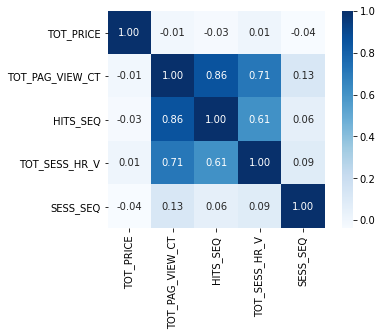

In [31]:
prpvcorr=prdmcs[['TOT_PRICE', 'TOT_PAG_VIEW_CT','HITS_SEQ', 'TOT_SESS_HR_V', 'SESS_SEQ']].corr(method='pearson')
prpvcorr

df_heatmap = sns.heatmap(prpvcorr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Blues')
df_heatmap #굳이 그려봤음. 


In [32]:
#HITS_SEQ 이상치 제거
#HIT가 1이라고 해서 무조건 오류가 아니다. SESS_SEQ가 2이상이면 그러니깐 이전 세션에서 다 장바구니에 담아놨으면 다음세션에서 한 번에 구매가 가능하긴 하다. 
#따라서 HIT가 1이면서 SESS_SEQ도 1인 경우가 오류라고 봐야겠다. 
hit_1 = prdmcs['HITS_SEQ'] ==1
sseq_1 = prdmcs['SESS_SEQ'] == 1

subset_df = prdmcs[hit_1&sseq_1]
subset_df

#없음 고로 Hit가 1이라고 하여 이상치니깐 제거해야겠다고 하면 안됨. 그러나 따로 처리를 하지 않고 냅두면 마치 오자마자 바로 산 것처럼 반영이 된다. 
#또 소비자가 접속한 날의 총량이 아니라 부여된 하나의 세션 내에서 이루어진 Hit을 의미한다. 
# 따라서 구매 시점에서의 세션에서 얼마나 많은 HIT을 했냐로 봐야된다.
# Hit와 SESS_HR의 상관관계는 높은데 Hit와 SESS_SEQ는 현저하게 낮다. 

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLAC5_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,TOT_PRICE


In [34]:
des = prdmcs[['HITS_SEQ','TOT_SESS_HR_V', 'TOT_PAG_VIEW_CT', 'SESS_SEQ','TOT_PRICE']].describe()
pd.options.display.float_format = '{:.2f}'.format #소수점 두번째까지 표시
des

,HITS_SEQ,TOT_SESS_HR_V,TOT_PAG_VIEW_CT,SESS_SEQ,TOT_PRICE
count,3961726.00,3961726.00,3961726.00,3961726.00,3961726.00
mean,88.58,1684.90,111.80,207.33,52960.55
std,89.45,1701.15,105.50,311.53,118103.84
min,1.00,1.00,1.00,1.00,90.00
25%,28.00,506.00,38.00,22.00,14400.00
50%,56.00,1164.00,75.00,84.00,29000.00
75%,115.00,2320.00,148.00,262.00,53000.00
max,500.00,39329.00,499.00,5981.00,17779000.00


In [75]:
prdmcs_aa = prdmcs.groupby(['CLNT_ID', 'SESS_ID'], as_index=False)[['PD_BUY_AM','PD_BUY_CT']].sum()
prdmcs_aa.head(20)

,CLNT_ID,SESS_ID,PD_BUY_AM,PD_BUY_CT
0,0000008,06964877,38000,1
1,0000008,07017688,38000,1
2,0000014,01156991,69800,2
3,0000032,00759569,19800,2
4,0000032,01136737,57000,3
5,0000056,02108568,9000,2
6,0000056,05747479,14800,1
7,0000058,04328876,131100,6
8,0000059,00400685,63400,2
9,0000059,00425903,23300,4


In [58]:
prdmcs_group = prdmcs.groupby(['CLNT_ID', 'SESS_ID'])[['PD_C']].count()
prdmcs_group.head(20)

PD_C
CLNT_ID SESS_ID       
0000008 06964877     1
        07017688     1
0000014 01156991     2
0000032 00759569     2
        01136737     3
0000056 02108568     2
        05747479     1
0000058 04328876     6
0000059 00400685     2
        00425903     3
0000063 01208688     5
        01330133     1
        01531580     1
        06634702     3
        10816644     1
0000064 10019105     1
        10022329     1
0000068 03020601     1
        04237632     1
        04610298     2

In [64]:
len(prdmcs_aa)
len(prdmcs_group)

2212849

2212849

In [68]:
a=sum(prdmcs_aa['PD_BUY_CT']==prdmcs_group['PD_C'])
a.count(False)

AttributeError: ignored

In [ ]:
cnt = search.groupby(['CLNT_ID','SESS_ID']).count()['KWD_NM'] # 순서 유의.
search = search.groupby(['CLNT_ID','SESS_ID']).sum() # 이 부분에서 고유한 키값으로 줄어듬. 
search['KWD_CNT'] = cnt

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


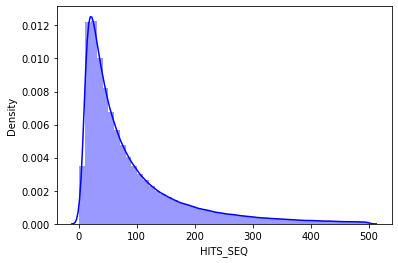

In [ ]:
#Hits의 분포 시각화
sns.distplot(prdmcs['HITS_SEQ'], color="blue", label="HITS_SEQ")

## 불필요 변수 다 제거했으니, 필요한 변수 생성할 차례

In [ ]:
#구매 상품 가격과 개수에 따른 소비자의 총 구매가격 변수(TOT_PRICE) 생성
prdmcs['TOT_PRICE'] = prdmcs['PD_BUY_AM']*prdmcs['PD_BUY_CT']
prdmcs.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,TOT_PRICE
6,4140076,10189797,13,570603,데상트,39000,2,스포츠패션,준내구재,F,40.0,172,20180413,18.0,113.0,mobile,78000
7,4140076,10189797,13,411029,아디다스(의류),29000,1,스포츠패션,준내구재,F,40.0,172,20180413,18.0,113.0,mobile,29000
13,4144914,07935714,12,554336,아디다스 키즈,39000,1,유아동의류,준내구재,M,40.0,24,20180521,13.0,107.0,mobile,39000
16,4147643,04050743,66,149995,앵글로매니아,39000,1,패션잡화,준내구재,F,30.0,18,20180724,73.0,3850.0,mobile,39000
19,4148106,06537318,21,570603,데상트,39000,1,스포츠패션,준내구재,F,30.0,58,20180613,20.0,144.0,mobile,39000


그러나 단순히 위와 같이 TOT_PRICE로 하면 어쨌거나 같은 HITS 내(장바구니)에서 구매한 것이 반영되지 않는다. 오히려 편향을 발생시킨다. 

현재의 데이터셋 구조상 속성이 다른 상품이어도 같은 정보탐색량을 한 것처럼 보인다. 

예를 들어 홍길동이 A-1세션에서 맥북 프로와 치약을 구매했다고 치자. 맥북프로는 찾는 데는 1시간 쓰고, 오지게 싼 치약 찾는데는 30초 써서 구매시점까지 정보탐색에 총 1시간 30초를 사용했다.

그런데 구매시점에 대한 데이터만 존재하기 때문에 어떤 상품에 얼마만큼의 정보 탐색을 했는지 알 수 없다. 

동일한 SESS_ID의 동일한 HITS_SEQ 내에서 구매 상품의 수, 서로 다른 품목의 수, 총 구매금액은 비교해볼 수 있을 것 같다. 

아래 예시 참고

In [ ]:
prdmcs[prdmcs['SESS_ID']=='10784068']

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM
59,4184092,10784068,141,457359,디스커버리,39000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
60,4184092,10784068,89,457189,디스커버리,159000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
61,4184092,10784068,141,541470,아디다스(슈즈),25000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
62,4184092,10784068,141,450215,디스커버리,29400,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
63,4184092,10784068,141,417814,노스페이스,32000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
64,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
65,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
66,4184092,10784068,141,546782,디스커버리,35400,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile


In [ ]:
#정보탐색 변수에 편향을 불러일으키는 데이터 예시이다. 
#[4184092]씨는 2018년 4월 4일 140번의 클릭 과정에서 7개의 상품을 장바구니에 담아 141번째 클릭에 구매했다. 
# 그런데 7개 상품 모두 같은 세션에서 구매했기 때문에 세션 유지 시간과 조회 페이지 뷰가 같다. 각 상품에 할애한 페이지 뷰와 시간을 알 수가 없다!
is_10= prdmcs['SESS_ID']=='10784068'
is_141 = prdmcs['HITS_SEQ']==141
subset_df = prdmcs[is_10 & is_141]
subset_df

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLAC1_NM,CLAC4_NM,CLNT_GENDER,CLNT_AGE,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM
59,4184092,10784068,141,457359,디스커버리,39000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
61,4184092,10784068,141,541470,아디다스(슈즈),25000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
62,4184092,10784068,141,450215,디스커버리,29400,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
63,4184092,10784068,141,417814,노스페이스,32000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
64,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
65,4184092,10784068,141,540816,노스페이스,35000,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile
66,4184092,10784068,141,546782,디스커버리,35400,1,스포츠패션,준내구재,F,40.0,127,20180404,257.0,4162.0,mobile


In [ ]:
srchcsv='/content/drive/My Drive/DataSet/Lpoint/data/Search1.csv'
search1 = pd.read_csv(srchcsv, dtype={"CLNT_ID":np.str, "SESS_ID":np.str})

srch2csv='/content/drive/My Drive/DataSet/Lpoint/data/Search2.csv'
search2 = pd.read_csv(srch2csv)

In [ ]:
search2['SESS_DT'] = pd.to_datetime(search2['SESS_DT'], format = '%Y%m%d')

In [ ]:
search2['SEARCH_CNT'] = search2['SEARCH_CNT'].astype(str)
search2['SEARCH_CNT'] = list(map(lambda x:x.replace(",",""), search2['SEARCH_CNT']))
search2['SEARCH_CNT'] =  search2['SEARCH_CNT'].astype(int)
search2.rename(columns={'SEARCH_CNT': 'SEARCH_TOT'}, inplace=True) # Search1과 컬럼명이 동일하지만 의미가 다르므로 이름 변경.

In [ ]:
#11월 30일 아래 코드 참고해서 CLNT_ID, SESS_IT 별로 groupby해서 가격과 상품 구매 수를 구해야함. 

search = pd.merge(search1,session.loc[:,['CLNT_ID','SESS_ID','SESS_DT']],how = 'left', on = ['CLNT_ID','SESS_ID']) 
search = pd.merge(search,search2.loc[:,['SESS_DT','KWD_NM','SEARCH_TOT']],how = 'left', on = ['KWD_NM','SESS_DT'])
cnt = search.groupby(['CLNT_ID','SESS_ID']).count()['KWD_NM'] # 순서 유의.
search = search.groupby(['CLNT_ID','SESS_ID']).sum() # 이 부분에서 고유한 키값으로 줄어듬. 
search['KWD_CNT'] = cnt
search['SEARCH_RATIO'] = search.SEARCH_CNT / search.SEARCH_TOT  

In [ ]:
search.head(20)

SEARCH_CNT  SEARCH_TOT  KWD_CNT  SEARCH_RATIO
CLNT_ID SESS_ID                                                
0000014 01156991           5         339        4      0.014749
0000025 05317297           7          12        2      0.583333
        06059256           1          13        1      0.076923
        08113243          11          13        2      0.846154
        09506206           2           2        1      1.000000
0000033 08694850           4          47        2      0.085106
        10300429           6          62        2      0.096774
        10548225          12        1352        6      0.008876
0000056 02108568           3          14        1      0.214286
        05747479           2          20        1      0.100000
0000058 04328876          18        1232       10      0.014610
0000063 01208688           2         283        2      0.007067
        01330133           1          93        1      0.010753
        06634702           1         107        1      0.009346
        10816644           3         558        3      0.005376
0000068 03020601           1          10        1      0.100000
        04614789          15         128        5      0.117188
        04715260           1           3        1      0.333333
0000071 04825972           2          10        1      0.200000
        10274463           2           3        1      0.666667

## 이제 본격적으로 데이터를 탐색해본다.

In [ ]:
totpricebyclac1 = pd.DataFrame(prdmaster[['CLAC1_NM','TOT_PRICE']].groupby(['CLAC1_NM']).sum())
totpricebyclac1['PER'] =(totpricebyclac1['TOT_PRICE']/(prd['TOT_PRICE'].sum()))*100
totpricebyclac1.sort_values(by='PER', ascending=False).head(10) #대분류별 매출액과 전체 매출액 비율 Top10
clntbyclac1.sort_values(by='PER', ascending=False).head(10) #대분류별 주문 빈도와 비율 Top10

NameError: ignored

애초에 사람들의 성향 때문에 발생하는 편향을 어떻게 찾아내고 제거할 수 있을까? 예를 들어, 샴푸 하나를 사도 온갖걸 다뒤져보는 사람들이 있을텐데 CLNT_ID를 고려하지 않고 SESS_ID로만 구분된 구매이력을 분석하면 이런 편향이 모두 포함된다. 데이터를 더 깨끗하게 하려면 어찌해야하나

## Search1, 2를 뭐 어떻게든 해보자

## 11월 30일 
그냥 일단 이 데이터는 없다고 가정하고 연구 주제 및 목적에 따라 최대한 이 데이터셋과 비슷하게 실험을 설계한 뒤, 맞춰나가는 형식으로 가야겠다. 그러다가 정안되면 그냥 분석 안하고 설계 단계까지만 써서 내야징